## Kinetic simulations

In [1]:
import numpy as np
import pandas as pd
import pyro
import pyro.distributions as dist
import torch
import matplotlib.pyplot as plt
from collections import defaultdict
from matplotlib.patches import Circle
from matplotlib.ticker import FormatStrFormatter
from pathlib import Path
from pyro.ops.stats import hpdi, quantile

from tapqir.models import Cosmos
from tapqir.utils.imscroll import count_intervals, time_to_first_binding, \
    association_rate, dissociation_rate, bootstrap, posterior_estimate, \
    bound_dwell_times, unbound_dwell_times, sample_and_bootstrap

### Load results

In [2]:
EXAMLES_DIR = Path.cwd().resolve().parent.parent.parent / "examples" / "data"

In [3]:
truth = {}
fit = {}
predictions = defaultdict(dict)
models = {}
for data_path in EXAMLES_DIR.iterdir():
    if data_path.is_dir() and data_path.name.startswith("kon"):
        truth[data_path.name] = pd.read_csv(
            data_path / "simulated_params.csv",
            squeeze=True, index_col=0
        ).rename(data_path.name)
        
        param_path = data_path / "runs/cosmos/v1.1.6/S1/control/lr0.005/bs64/"
        
        fit[data_path.name] = pd.read_csv(
            param_path / "global_params.csv",
            squeeze=True,
            index_col=0
        ).rename(data_path.name)
        fit[data_path.name]["height"] = truth[data_path.name]["height"]
        
        models[data_path.name] = Cosmos()
        models[data_path.name].load(data_path, True, "cpu")
        models[data_path.name].load_parameters(param_path)
        mask = torch.from_numpy(models[data_path.name].data.labels["z"])
        samples = torch.masked_select(models[data_path.name].z_marginal, mask)
        predictions[data_path.name]["z_masked"] = samples
        low, high = hpdi(samples, 0.68)
        median = quantile(samples, 0.5)
        
        z_dist = dist.Bernoulli(models[data_path.name].z_marginal)
        intervals = count_intervals(models[data_path.name].z_map)
        # calculate kon from true ttfb
        ttfb = time_to_first_binding(models[data_path.name].data.labels["z"])
        ttfb = ttfb[ttfb > 0]
        kon = 1 / ttfb.mean()
        fit[data_path.name]["kon_true"] = kon.item()
        kon_low, kon_high = bootstrap(ttfb, lambda x: 1 / x.mean())
        fit[data_path.name]["kon_true_low"] = kon_low.item()
        fit[data_path.name]["kon_true_high"] = kon_high.item()
        
        # calculate kon from ttfb
        ttfb = time_to_first_binding(models[data_path.name].z_map)
        ttfb = ttfb[ttfb > 0]
        kon = 1 / ttfb.mean()
        fit[data_path.name]["kon_ttfb"] = kon.item()
        kon_low, kon_high = sample_and_bootstrap(
            z_dist,
            lambda x: 1 / x.mean(),
            preprocess=lambda x: time_to_first_binding(x)[time_to_first_binding(x)>0]
        )
        fit[data_path.name]["kon_ttfb_low"] = kon_low.item()
        fit[data_path.name]["kon_ttfb_high"] = kon_high.item()
        
        fit[data_path.name]["koff_ttfb"] = kon.item() / fit[data_path.name]["probs_z_1"] * fit[data_path.name]["probs_z_0"]

        # calculate kon from dwell times
        dwell_time = unbound_dwell_times(intervals)
        kon = 1 / dwell_time.mean()
        fit[data_path.name]["kon"] = kon.item()
        kon_low, kon_high = sample_and_bootstrap(
            z_dist,
            lambda x: 1 / x.mean(),
            preprocess=lambda x: unbound_dwell_times(count_intervals(x))
        )
        fit[data_path.name]["kon_low"] = kon_low.item()
        fit[data_path.name]["kon_high"] = kon_high.item()
        
        # calculate koff from dwell times
        dwell_time = bound_dwell_times(intervals)
        koff = 1 / dwell_time.mean()
        fit[data_path.name]["koff"] = koff.item()
        koff_low, koff_high = sample_and_bootstrap(
            z_dist,
            lambda x: 1 / x.mean(),
            preprocess=lambda x: bound_dwell_times(count_intervals(x))
        )
        fit[data_path.name]["koff_low"] = koff_low.item()
        fit[data_path.name]["koff_high"] = koff_high.item()
       
        # calculate kon from transition probabilities matrix
        A01 = association_rate(models[data_path.name].z_map)
        A01_low, A01_high = posterior_estimate(z_dist, association_rate)
        fit[data_path.name]["A01"] = A01.item()
        fit[data_path.name]["A01_low"] = A01_low.item()
        fit[data_path.name]["A01_high"] = A01_high.item()
        
        # calculate koff from transition probabilities matrix
        A10 = dissociation_rate(models[data_path.name].z_map)
        A10_low, A10_high = posterior_estimate(z_dist, dissociation_rate)
        fit[data_path.name]["A10"] = A10.item()
        fit[data_path.name]["A10_low"] = A10_low.item()
        fit[data_path.name]["A10_high"] = A10_high.item()

In [12]:
truth_df = pd.concat(truth.values(), axis=1).T
truth_df

,gain,kon,koff,rate_j,proximity,offset,height,background
kon3.00e-02ratej1.00e+00,7.0,0.03,0.2,1.00,0.2,90.0,3000.0,150.0
kon1.00e-02ratej1.00e+00,7.0,0.01,0.2,1.00,0.2,90.0,3000.0,150.0
kon3.00e-02ratej1.50e-01,7.0,0.03,0.2,0.15,0.2,90.0,3000.0,150.0
kon1.00e-02ratej1.00e-02,7.0,0.01,0.2,0.01,0.2,90.0,3000.0,150.0
kon2.00e-02ratej1.00e+00,7.0,0.02,0.2,1.00,0.2,90.0,3000.0,150.0
kon3.00e-02ratej5.00e-01,7.0,0.03,0.2,0.50,0.2,90.0,3000.0,150.0
kon2.00e-02ratej5.00e-01,7.0,0.02,0.2,0.50,0.2,90.0,3000.0,150.0
kon2.00e-02ratej1.00e-02,7.0,0.02,0.2,0.01,0.2,90.0,3000.0,150.0
kon3.00e-02ratej1.00e-02,7.0,0.03,0.2,0.01,0.2,90.0,3000.0,150.0
kon1.00e-02ratej1.50e-01,7.0,0.01,0.2,0.15,0.2,90.0,3000.0,150.0


In [13]:
fit_df = pd.concat(fit.values(), axis=1).T
fit_df = fit_df.drop(
    ["width_mean_0", "width_size_0", "height_scale", "height"],
    axis=1
)
fit_df

,-ELBO,proximity_0,gain,probs_z_0,probs_z_1,rate_j,MCC,Recall,Precision,FN,...,kon_high,koff,koff_low,koff_high,A01,A01_low,A01_high,A10,A10_low,A10_high
kon3.00e-02ratej1.00e+00,198402416.0,0.212721,7.074045,0.880973,0.119027,0.967912,0.919860,0.911285,0.948998,1143.0,...,0.046450,0.305168,0.320435,0.329912,0.042870,0.044368,0.044778,0.303957,0.322378,0.325487
kon1.00e-02ratej1.00e+00,198348288.0,0.215698,7.072728,0.956787,0.043213,0.976319,0.884693,0.880829,0.899661,575.0,...,0.021978,0.369002,0.404915,0.423973,0.018302,0.019041,0.019380,0.368644,0.409580,0.418186
kon3.00e-02ratej1.50e-01,193252784.0,0.209326,7.023105,0.869527,0.130473,0.151723,0.981657,0.980088,0.988048,262.0,...,0.038392,0.229673,0.237913,0.246448,0.034274,0.036320,0.036645,0.228433,0.239993,0.241939
kon1.00e-02ratej1.00e-02,192369024.0,0.205118,7.018451,0.950517,0.049483,0.010081,0.996517,0.997098,0.996273,14.0,...,0.013287,0.209361,0.215173,0.228021,0.010602,0.011272,0.011442,0.208377,0.218653,0.221474
kon2.00e-02ratej1.00e+00,198391696.0,0.211918,7.066543,0.916703,0.083297,0.968362,0.909965,0.902205,0.934026,887.0,...,0.034104,0.319866,0.339933,0.352303,0.030556,0.031751,0.032126,0.318903,0.342904,0.347260
kon3.00e-02ratej5.00e-01,195557904.0,0.211141,7.050582,0.872335,0.127665,0.495139,0.951257,0.944298,0.971164,741.0,...,0.042371,0.260737,0.268820,0.277574,0.038563,0.040061,0.040408,0.260019,0.271455,0.273825
kon2.00e-02ratej5.00e-01,195498032.0,0.209449,7.048267,0.912512,0.087488,0.495192,0.945413,0.940609,0.960279,548.0,...,0.030719,0.276781,0.287056,0.298174,0.027391,0.028423,0.028726,0.275908,0.290465,0.293776
kon2.00e-02ratej1.00e-02,192445760.0,0.207034,7.027198,0.908434,0.091566,0.010145,0.997180,0.998146,0.996732,17.0,...,0.023594,0.202581,0.209036,0.218466,0.020357,0.021607,0.021844,0.201418,0.211013,0.213004
kon3.00e-02ratej1.00e-02,192505600.0,0.207121,7.027124,0.871321,0.128679,0.010114,0.997778,0.998761,0.997370,16.0,...,0.033524,0.202114,0.208734,0.216161,0.029866,0.031695,0.031998,0.200930,0.210389,0.211938
kon1.00e-02ratej1.50e-01,193123424.0,0.210434,7.029120,0.952291,0.047709,0.152019,0.971233,0.971813,0.973427,136.0,...,0.015948,0.246446,0.261773,0.277653,0.012452,0.013605,0.013866,0.245636,0.266416,0.270582


### Figure 6

#### Keq

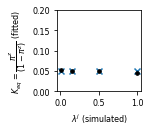

In [79]:
plt.figure(figsize=(1.5, 1.5))
mask = truth_df["kon"] == 0.01
keq_sim = truth_df.loc[mask, "kon"] / truth_df.loc[mask, "koff"]
keq_fit = fit_df.loc[mask, "probs_z_1"] / fit_df.loc[mask, "probs_z_0"]
plt.scatter(truth_df.loc[mask, "rate_j"], keq_sim, marker="x")
plt.scatter(truth_df.loc[mask, "rate_j"], keq_fit, color="k", s=13)
plt.ylim(0, 0.2)
#plt.xlim(0, 0.2)
plt.yticks(fontsize=8)
plt.xticks([0, 0.5, 1], fontsize=8)
plt.xlabel(r"$\lambda^{j}$ (simulated)", fontsize=8)
plt.ylabel(r"$K_{eq} = \dfrac{\pi^z}{(1-\pi^z)}$ (fitted)", fontsize=8)
plt.savefig("/tmp/keq1.svg")
plt.show()

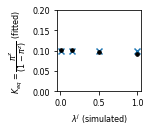

In [80]:
plt.figure(figsize=(1.5, 1.5))
mask = truth_df["kon"] == 0.02
keq_sim = truth_df.loc[mask, "kon"] / truth_df.loc[mask, "koff"]
keq_fit = fit_df.loc[mask, "probs_z_1"] / fit_df.loc[mask, "probs_z_0"]
plt.scatter(truth_df.loc[mask, "rate_j"], keq_sim, marker="x")
plt.scatter(truth_df.loc[mask, "rate_j"], keq_fit, color="k", s=13)
plt.ylim(0, 0.2)
#plt.xlim(0, 0.2)
plt.yticks(fontsize=8)
plt.xticks([0, 0.5, 1], fontsize=8)
plt.xlabel(r"$\lambda^{j}$ (simulated)", fontsize=8)
plt.ylabel(r"$K_{eq} = \dfrac{\pi^z}{(1-\pi^z)}$ (fitted)", fontsize=8)
plt.savefig("/tmp/keq2.svg")
plt.show()

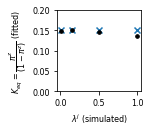

In [81]:
plt.figure(figsize=(1.5, 1.5))
mask = truth_df["kon"] == 0.03
keq_sim = truth_df.loc[mask, "kon"] / truth_df.loc[mask, "koff"]
keq_fit = fit_df.loc[mask, "probs_z_1"] / fit_df.loc[mask, "probs_z_0"]
plt.scatter(truth_df.loc[mask, "rate_j"], keq_sim, marker="x")
plt.scatter(truth_df.loc[mask, "rate_j"], keq_fit, color="k", s=13)
plt.ylim(0, 0.2)
#plt.xlim(0, 0.2)
plt.yticks(fontsize=8)
plt.xticks([0, 0.5, 1], fontsize=8)
plt.xlabel(r"$\lambda^{j}$ (simulated)", fontsize=8)
plt.ylabel(r"$K_{eq} = \dfrac{\pi^z}{(1-\pi^z)}$ (fitted)", fontsize=8)
plt.savefig("/tmp/keq3.svg")
plt.show()

In [68]:
fit_df["A01"] / fit_df["A10"]

kon3.00e-02ratej1.00e+00    0.141041
kon1.00e-02ratej1.00e+00    0.049647
kon3.00e-02ratej1.50e-01    0.150039
kon1.00e-02ratej1.00e-02    0.050879
kon2.00e-02ratej1.00e+00    0.095815
kon3.00e-02ratej5.00e-01    0.148310
kon2.00e-02ratej5.00e-01    0.099277
kon2.00e-02ratej1.00e-02    0.101069
kon3.00e-02ratej1.00e-02    0.148637
kon1.00e-02ratej1.50e-01    0.050691
kon2.00e-02ratej1.50e-01    0.100767
kon1.00e-02ratej5.00e-01    0.050598
dtype: float64

#### Time-to-first binding

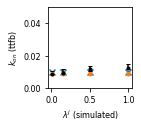

In [20]:
plt.figure(figsize=(1.5, 1.5))
mask = truth_df["kon"] == 0.01
plt.scatter(truth_df.loc[mask, "rate_j"], truth_df.loc[mask, "kon"], marker="x")
plt.errorbar(truth_df.loc[mask, "rate_j"], fit_df.loc[mask, "kon_true"],
             yerr=abs(fit_df.loc[mask, ["kon_true_low", "kon_true_high"]].values.T-fit_df.loc[mask, "kon_true"].values),
             fmt="o", ms=3, mfc="C1", mec="C1", ecolor="C1", capsize=2)
plt.errorbar(truth_df.loc[mask, "rate_j"], fit_df.loc[mask, "kon_ttfb"],
             yerr=abs(fit_df.loc[mask, ["kon_ttfb_low", "kon_ttfb_high"]].values.T-fit_df.loc[mask, "kon_ttfb"].values),
             fmt="o", ms=3, mfc="k", mec="k", ecolor="k", capsize=2)
plt.ylim(0, 0.05)
#plt.xlim(0, 0.3)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xticks([0, 0.5, 1], fontsize=8)
plt.xlabel(r"$\lambda^{j}$ (simulated)", fontsize=8)
plt.ylabel(r"$k_{on}$ (ttfb)", fontsize=8)
plt.savefig("/tmp/kon1-ttfb.svg")
plt.show()

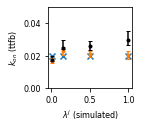

In [21]:
plt.figure(figsize=(1.5, 1.5))
mask = truth_df["kon"] == 0.02
plt.scatter(truth_df.loc[mask, "rate_j"], truth_df.loc[mask, "kon"], marker="x")
plt.errorbar(truth_df.loc[mask, "rate_j"], fit_df.loc[mask, "kon_true"],
             yerr=abs(fit_df.loc[mask, ["kon_true_low", "kon_true_high"]].values.T-fit_df.loc[mask, "kon_true"].values),
             fmt="o", ms=3, mfc="C1", mec="C1", ecolor="C1", capsize=2)
plt.errorbar(truth_df.loc[mask, "rate_j"], fit_df.loc[mask, "kon_ttfb"],
             yerr=abs(fit_df.loc[mask, ["kon_ttfb_low", "kon_ttfb_high"]].values.T-fit_df.loc[mask, "kon_ttfb"].values),
             fmt="o", ms=3, mfc="k", mec="k", ecolor="k", capsize=2)
plt.ylim(0, 0.05)
#plt.xlim(0, 0.3)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xticks([0, 0.5, 1], fontsize=8)
plt.xlabel(r"$\lambda^{j}$ (simulated)", fontsize=8)
plt.ylabel(r"$k_{on}$ (ttfb)", fontsize=8)
plt.savefig("/tmp/kon2-ttfb.svg")
plt.show()

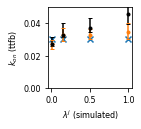

In [22]:
plt.figure(figsize=(1.5, 1.5))
mask = truth_df["kon"] == 0.03
plt.scatter(truth_df.loc[mask, "rate_j"], truth_df.loc[mask, "kon"], marker="x")
plt.errorbar(truth_df.loc[mask, "rate_j"], fit_df.loc[mask, "kon_true"],
             yerr=abs(fit_df.loc[mask, ["kon_true_low", "kon_true_high"]].values.T-fit_df.loc[mask, "kon_true"].values),
             fmt="o", ms=3, mfc="C1", mec="C1", ecolor="C1", capsize=2)
plt.errorbar(truth_df.loc[mask, "rate_j"], fit_df.loc[mask, "kon_ttfb"],
             yerr=abs(fit_df.loc[mask, ["kon_ttfb_low", "kon_ttfb_high"]].values.T-fit_df.loc[mask, "kon_ttfb"].values),
             fmt="o", ms=3, mfc="k", mec="k", ecolor="k", capsize=2)
plt.ylim(0, 0.05)
#plt.xlim(0, 0.3)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xticks([0, 0.5, 1], fontsize=8)
plt.xlabel(r"$\lambda^{j}$ (simulated)", fontsize=8)
plt.ylabel(r"$k_{on}$ (ttfb)", fontsize=8)
plt.savefig("/tmp/kon3-ttfb.svg")
plt.show()

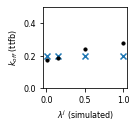

In [29]:
plt.figure(figsize=(1.5, 1.5))
mask = truth_df["kon"] == 0.01
plt.scatter(truth_df.loc[mask, "rate_j"], truth_df.loc[mask, "koff"], marker="x")
plt.scatter(truth_df.loc[mask, "rate_j"], fit_df.loc[mask, "koff_ttfb"], marker="o", s=10, color="k")
plt.ylim(0, 0.5)
#plt.xlim(0, 0.3)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xticks([0, 0.5, 1], fontsize=8)
plt.xlabel(r"$\lambda^{j}$ (simulated)", fontsize=8)
plt.ylabel(r"$k_{off}$ (ttfb)", fontsize=8)
plt.savefig("/tmp/koff1-ttfb.svg")
plt.show()

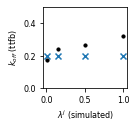

In [30]:
plt.figure(figsize=(1.5, 1.5))
mask = truth_df["kon"] == 0.02
plt.scatter(truth_df.loc[mask, "rate_j"], truth_df.loc[mask, "koff"], marker="x")
plt.scatter(truth_df.loc[mask, "rate_j"], fit_df.loc[mask, "koff_ttfb"], marker="o", s=10, color="k")
plt.ylim(0, 0.5)
#plt.xlim(0, 0.3)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xticks([0, 0.5, 1], fontsize=8)
plt.xlabel(r"$\lambda^{j}$ (simulated)", fontsize=8)
plt.ylabel(r"$k_{off}$ (ttfb)", fontsize=8)
plt.savefig("/tmp/koff2-ttfb.svg")
plt.show()

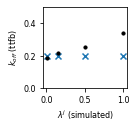

In [31]:
plt.figure(figsize=(1.5, 1.5))
mask = truth_df["kon"] == 0.03
plt.scatter(truth_df.loc[mask, "rate_j"], truth_df.loc[mask, "koff"], marker="x")
plt.scatter(truth_df.loc[mask, "rate_j"], fit_df.loc[mask, "koff_ttfb"], marker="o", s=10, color="k")
plt.ylim(0, 0.5)
#plt.xlim(0, 0.3)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xticks([0, 0.5, 1], fontsize=8)
plt.xlabel(r"$\lambda^{j}$ (simulated)", fontsize=8)
plt.ylabel(r"$k_{off}$ (ttfb)", fontsize=8)
plt.savefig("/tmp/koff3-ttfb.svg")
plt.show()

#### Dwell time

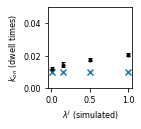

In [32]:
plt.figure(figsize=(1.5, 1.5))
mask = truth_df["kon"] == 0.01
plt.scatter(truth_df.loc[mask, "rate_j"], truth_df.loc[mask, "kon"], marker="x")
plt.errorbar(truth_df.loc[mask, "rate_j"], fit_df.loc[mask, "kon"],
             yerr=abs(fit_df.loc[mask, ["kon_low", "kon_high"]].values.T-fit_df.loc[mask, "kon"].values),
             fmt="o", ms=3, mfc="k", mec="k", ecolor="k", capsize=2)
plt.ylim(0, 0.05)
#plt.xlim(0, 0.3)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xticks([0, 0.5, 1], fontsize=8)
plt.xlabel(r"$\lambda^{j}$ (simulated)", fontsize=8)
plt.ylabel(r"$k_{on}$ (dwell times)", fontsize=8)
plt.savefig("/tmp/kon1-dt.svg")
plt.show()

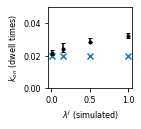

In [33]:
plt.figure(figsize=(1.5, 1.5))
mask = truth_df["kon"] == 0.02
plt.scatter(truth_df.loc[mask, "rate_j"], truth_df.loc[mask, "kon"], marker="x")
plt.errorbar(truth_df.loc[mask, "rate_j"], fit_df.loc[mask, "kon"],
             yerr=abs(fit_df.loc[mask, ["kon_low", "kon_high"]].values.T-fit_df.loc[mask, "kon"].values),
             fmt="o", ms=3, mfc="k", mec="k", ecolor="k", capsize=2)
plt.ylim(0, 0.05)
#plt.xlim(0, 0.3)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xticks([0, 0.5, 1], fontsize=8)
plt.xlabel(r"$\lambda^{j}$ (simulated)", fontsize=8)
plt.ylabel(r"$k_{on}$ (dwell times)", fontsize=8)
plt.savefig("/tmp/kon2-dt.svg")
plt.show()

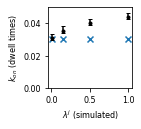

In [34]:
plt.figure(figsize=(1.5, 1.5))
mask = truth_df["kon"] == 0.03
plt.scatter(truth_df.loc[mask, "rate_j"], truth_df.loc[mask, "kon"], marker="x")
plt.errorbar(truth_df.loc[mask, "rate_j"], fit_df.loc[mask, "kon"],
             yerr=abs(fit_df.loc[mask, ["kon_low", "kon_high"]].values.T-fit_df.loc[mask, "kon"].values),
             fmt="o", ms=3, mfc="k", mec="k", ecolor="k", capsize=2)
plt.ylim(0, 0.05)
#plt.xlim(0, 0.3)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xticks([0, 0.5, 1], fontsize=8)
plt.xlabel(r"$\lambda^{j}$ (simulated)", fontsize=8)
plt.ylabel(r"$k_{on}$ (dwell times)", fontsize=8)
plt.savefig("/tmp/kon3-dt.svg")
plt.show()

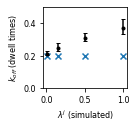

In [35]:
plt.figure(figsize=(1.5, 1.5))
mask = truth_df["kon"] == 0.01
plt.scatter(truth_df.loc[mask, "rate_j"], truth_df.loc[mask, "koff"], marker="x")
plt.errorbar(truth_df.loc[mask, "rate_j"], fit_df.loc[mask, "koff"],
             yerr=abs(fit_df.loc[mask, ["koff_low", "koff_high"]].values.T-fit_df.loc[mask, "koff"].values),
             fmt="o", ms=3, mfc="k", mec="k", ecolor="k", capsize=2)
plt.ylim(0, 0.5)
#plt.xlim(0, 0.3)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xticks([0, 0.5, 1], fontsize=8)
plt.xlabel(r"$\lambda^{j}$ (simulated)", fontsize=8)
plt.ylabel(r"$k_{off}$ (dwell times)", fontsize=8)
plt.savefig("/tmp/koff1-dt.svg")
plt.show()

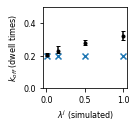

In [36]:
plt.figure(figsize=(1.5, 1.5))
mask = truth_df["kon"] == 0.02
plt.scatter(truth_df.loc[mask, "rate_j"], truth_df.loc[mask, "koff"], marker="x")
plt.errorbar(truth_df.loc[mask, "rate_j"], fit_df.loc[mask, "koff"],
             yerr=abs(fit_df.loc[mask, ["koff_low", "koff_high"]].values.T-fit_df.loc[mask, "koff"].values),
             fmt="o", ms=3, mfc="k", mec="k", ecolor="k", capsize=2)
plt.ylim(0, 0.5)
#plt.xlim(0, 0.3)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xticks([0, 0.5, 1], fontsize=8)
plt.xlabel(r"$\lambda^{j}$ (simulated)", fontsize=8)
plt.ylabel(r"$k_{off}$ (dwell times)", fontsize=8)
plt.savefig("/tmp/koff2-dt.svg")
plt.show()

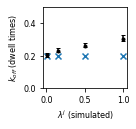

In [37]:
plt.figure(figsize=(1.5, 1.5))
mask = truth_df["kon"] == 0.03
plt.scatter(truth_df.loc[mask, "rate_j"], truth_df.loc[mask, "koff"], marker="x")
plt.errorbar(truth_df.loc[mask, "rate_j"], fit_df.loc[mask, "koff"],
             yerr=abs(fit_df.loc[mask, ["koff_low", "koff_high"]].values.T-fit_df.loc[mask, "koff"].values),
             fmt="o", ms=3, mfc="k", mec="k", ecolor="k", capsize=2)
plt.ylim(0, 0.5)
#plt.xlim(0, 0.3)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xticks([0, 0.5, 1], fontsize=8)
plt.xlabel(r"$\lambda^{j}$ (simulated)", fontsize=8)
plt.ylabel(r"$k_{off}$ (dwell times)", fontsize=8)
plt.savefig("/tmp/koff3-dt.svg")
plt.show()

#### Transition rates

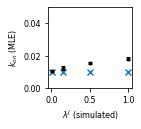

In [69]:
plt.figure(figsize=(1.5, 1.5))
mask = truth_df["kon"] == 0.01
plt.scatter(truth_df.loc[mask, "rate_j"], truth_df.loc[mask, "kon"], marker="x")
plt.errorbar(truth_df.loc[mask, "rate_j"], fit_df.loc[mask, "A01"],
             yerr=abs(fit_df.loc[mask, ["A01_low", "A01_high"]].values.T-fit_df.loc[mask, "A01"].values),
             fmt="o", ms=3, mfc="k", mec="k", ecolor="k", capsize=2)
plt.ylim(0, 0.05)
#plt.xlim(0, 0.3)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xticks([0, 0.5, 1], fontsize=8)
plt.xlabel(r"$\lambda^{j}$ (simulated)", fontsize=8)
plt.ylabel(r"$k_{on}$ (MLE)", fontsize=8)
plt.savefig("/tmp/a01-1.svg")
plt.show()

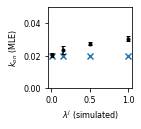

In [72]:
plt.figure(figsize=(1.5, 1.5))
mask = truth_df["kon"] == 0.02
plt.scatter(truth_df.loc[mask, "rate_j"], truth_df.loc[mask, "kon"], marker="x")
plt.errorbar(truth_df.loc[mask, "rate_j"], fit_df.loc[mask, "A01"],
             yerr=abs(fit_df.loc[mask, ["A01_low", "A01_high"]].values.T-fit_df.loc[mask, "A01"].values),
             fmt="o", ms=3, mfc="k", mec="k", ecolor="k", capsize=2)
plt.ylim(0, 0.05)
#plt.xlim(0, 0.3)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xticks([0, 0.5, 1], fontsize=8)
plt.xlabel(r"$\lambda^{j}$ (simulated)", fontsize=8)
plt.ylabel(r"$k_{on}$ (MLE)", fontsize=8)
plt.savefig("/tmp/a01-2.svg")
plt.show()

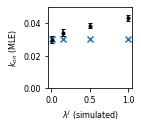

In [71]:
plt.figure(figsize=(1.5, 1.5))
mask = truth_df["kon"] == 0.03
plt.scatter(truth_df.loc[mask, "rate_j"], truth_df.loc[mask, "kon"], marker="x")
plt.errorbar(truth_df.loc[mask, "rate_j"], fit_df.loc[mask, "A01"],
             yerr=abs(fit_df.loc[mask, ["A01_low", "A01_high"]].values.T-fit_df.loc[mask, "A01"].values),
             fmt="o", ms=3, mfc="k", mec="k", ecolor="k", capsize=2)
plt.ylim(0, 0.05)
#plt.xlim(0, 0.3)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xticks([0, 0.5, 1], fontsize=8)
plt.xlabel(r"$\lambda^{j}$ (simulated)", fontsize=8)
plt.ylabel(r"$k_{on}$ (MLE)", fontsize=8)
plt.savefig("/tmp/a01-3.svg")
plt.show()

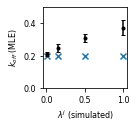

In [73]:
plt.figure(figsize=(1.5, 1.5))
mask = truth_df["kon"] == 0.01
plt.scatter(truth_df.loc[mask, "rate_j"], truth_df.loc[mask, "koff"], marker="x")
plt.errorbar(truth_df.loc[mask, "rate_j"], fit_df.loc[mask, "A10"],
             yerr=abs(fit_df.loc[mask, ["A10_low", "A10_high"]].values.T-fit_df.loc[mask, "A10"].values),
             fmt="o", ms=3, mfc="k", mec="k", ecolor="k", capsize=2)
plt.ylim(0, 0.5)
#plt.xlim(0, 0.3)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xticks([0, 0.5, 1], fontsize=8)
plt.xlabel(r"$\lambda^{j}$ (simulated)", fontsize=8)
plt.ylabel(r"$k_{off}$ (MLE)", fontsize=8)
plt.savefig("/tmp/a10-1.svg")
plt.show()

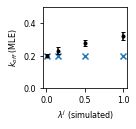

In [74]:
plt.figure(figsize=(1.5, 1.5))
mask = truth_df["kon"] == 0.02
plt.scatter(truth_df.loc[mask, "rate_j"], truth_df.loc[mask, "koff"], marker="x")
plt.errorbar(truth_df.loc[mask, "rate_j"], fit_df.loc[mask, "A10"],
             yerr=abs(fit_df.loc[mask, ["A10_low", "A10_high"]].values.T-fit_df.loc[mask, "A10"].values),
             fmt="o", ms=3, mfc="k", mec="k", ecolor="k", capsize=2)
plt.ylim(0, 0.5)
#plt.xlim(0, 0.3)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xticks([0, 0.5, 1], fontsize=8)
plt.xlabel(r"$\lambda^{j}$ (simulated)", fontsize=8)
plt.ylabel(r"$k_{off}$ (MLE)", fontsize=8)
plt.savefig("/tmp/a10-2.svg")
plt.show()

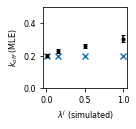

In [75]:
plt.figure(figsize=(1.5, 1.5))
mask = truth_df["kon"] == 0.03
plt.scatter(truth_df.loc[mask, "rate_j"], truth_df.loc[mask, "koff"], marker="x")
plt.errorbar(truth_df.loc[mask, "rate_j"], fit_df.loc[mask, "A10"],
             yerr=abs(fit_df.loc[mask, ["A10_low", "A10_high"]].values.T-fit_df.loc[mask, "A10"].values),
             fmt="o", ms=3, mfc="k", mec="k", ecolor="k", capsize=2)
plt.ylim(0, 0.5)
#plt.xlim(0, 0.3)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xticks([0, 0.5, 1], fontsize=8)
plt.xlabel(r"$\lambda^{j}$ (simulated)", fontsize=8)
plt.ylabel(r"$k_{off}$ (MLE)", fontsize=8)
plt.savefig("/tmp/a10-3.svg")
plt.show()

In [83]:
data_path = EXAMLES_DIR / "kon2.00e-02ratej1.00e+00"
param_path = data_path / "runs/cosmos/v1.1.6/S1/control/lr0.005/bs64/"

model = Cosmos()
model.load(data_path, True, "cpu")
model.load_parameters(param_path)

In [ ]:
plt.figure(figsize=(3.5,0.5))

plt.plot(
    np.arange(f1, f2),
    model.z_probs[:, n, f1:f2].sum(0),
    "o-", ms=2, lw=0.5, color="C2", label="on-target"
)
plt.plot(
    np.arange(f1, f2),
    1 - (1 - model.j_probs[:, n, f1:f2]).prod(0),
    "o-", ms=2, lw=0.5, color="C3", label="off-target"
)
plt.xticks([])
plt.yticks([0, 0.5, 1], fontsize=8)
plt.xlim(f1-0.5, f2-0.5)
plt.ylim(-0.15, 1.15)
plt.ylabel(r"$p$", fontsize=8)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))

plt.savefig("/tmp/grace-p.svg")
plt.show()

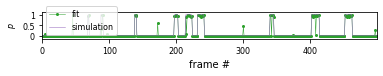

In [99]:
plt.figure(figsize=(6, 0.5))

f1 = 0
f2 = 500
plt.plot(
    model.data.drift.index[f1:f2],
    model.z_marginal[0, f1:f2],
    "o-", ms=2, lw=0.5, color="C2", label="fit")
plt.plot(
    model.data.drift.index[f1:f2],
    model.data.labels["z"][0, f1:f2],
    "-", lw=0.5, color="C4", label="simulation")

plt.xticks(fontsize=8)
plt.yticks([0, 0.5, 1], fontsize=8)
plt.xlim(f1-1, f2-1)
plt.ylim(-0.15, 1.15)
plt.ylabel(r"$p$", fontsize=8)
plt.xlabel("frame #")
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.legend(fontsize=8)

plt.savefig("/tmp/kinetic-trace.svg")
plt.show()

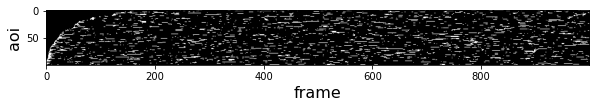

In [12]:
frames = np.arange(1, model.data.F+1)
q1 = np.ones((model.data.N, model.data.F))
q1[:, :-1] = model.data.labels["z"][:, 1:]
cumq0 = np.cumprod(1 - model.data.labels["z"], axis=-1)
sttfb = (frames * q1 * cumq0).sum(-1)

sdx = np.flip(np.argsort(sttfb))

figsize = torch.tensor([10, 10 * model.data.N / model.data.F])
plt.figure(figsize=figsize)

plt.imshow(model.data.labels["z"][sdx], cmap="gray")
plt.xlabel("frame", fontsize=16)
plt.ylabel("aoi", fontsize=16)
plt.show()

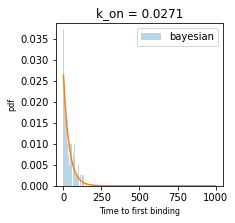

In [87]:
frames = torch.arange(1, model.data.F+1)
q1 = torch.ones(model.data.N, model.data.F)
q1[:, :-1] = model.z_marginal[:, 1:]
cumq0 = torch.cumprod(1 - model.z_marginal, dim=-1)
ttfb = (frames * q1 * cumq0).sum(-1) #/ (1 - model.z_marginal[:, 0])
ttfb = ttfb - 1
mask = ttfb > 0
ttfb = ttfb[mask]

kon = 1 / ttfb.mean()

plt.figure(figsize=(3, 3))
plt.title(f"k_on = {kon:.4f}")
plt.hist(ttfb.numpy(), bins=30, density=True, alpha=0.3, label="bayesian")
# plt.hist(sttfb, bins=20, density=True, alpha=0.3, label="spotpicker")
x = torch.arange(1,model.data.F)
d = dist.Exponential(kon)
plt.plot(x, d.log_prob(x).exp())
plt.xlabel("Time to first binding", fontsize=8)
plt.ylabel("pdf", fontsize=8)
# plt.xlim(0, 100)
plt.legend()
plt.show()

### Analysis

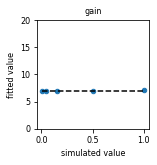

In [23]:
plt.figure(figsize=(2, 2))
plt.title("gain", fontsize=8)
plt.plot(truth_df["rate_j"].sort_values(), truth_df["gain"].sort_values(), "k--")
plt.scatter(truth_df["rate_j"], fit_df["gain"], s=20)
plt.ylim(0, 20)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel("simulated value", fontsize=8)
plt.ylabel("fitted value", fontsize=8)
plt.show()

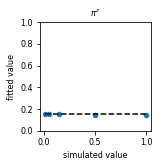

In [24]:
plt.figure(figsize=(2, 2))
plt.title(r"$\pi^z$", fontsize=8)
plt.plot(truth_df["rate_j"].sort_values(), truth_df["probs_z"].sort_values(), "k--")
plt.scatter(truth_df["rate_j"], fit_df["probs_z_1"], s=20)
plt.ylim(0, 1)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel("simulated value", fontsize=8)
plt.ylabel("fitted value", fontsize=8)
plt.show()

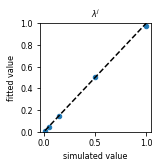

In [25]:
plt.figure(figsize=(2, 2))
plt.title(r"$\lambda^j$", fontsize=8)
plt.plot(truth_df["rate_j"].sort_values(), truth_df["rate_j"].sort_values(), "k--")
plt.scatter(truth_df["rate_j"], fit_df["rate_j"], s=20)
plt.ylim(0, 1.)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel("simulated value", fontsize=8)
plt.ylabel("fitted value", fontsize=8)
plt.show()

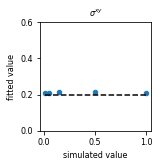

In [26]:
plt.figure(figsize=(2, 2))
plt.title(r"$\sigma^{xy}$", fontsize=8)
plt.plot(truth_df["rate_j"].sort_values(), truth_df["proximity"].sort_values(), "k--")
plt.scatter(truth_df["rate_j"], fit_df["proximity_0"], s=20)
plt.ylim(0., 0.6)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel("simulated value", fontsize=8)
plt.ylabel("fitted value", fontsize=8)
plt.show()